In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Lambda, GlobalAveragePooling2D, BatchNormalization

# Define image dimensions and batch size
img_height, img_width = 300, 300
batch_size = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess the training data
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Leaf Disease Dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

# Load and preprocess the validation data
val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Leaf Disease Dataset/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify validation subset
)

# Define a function to invert colors
def invert_colors(x):
    return tf.reverse(x, axis=[-1])  # Invert color channels

# Build the CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Global Average Pooling and Inversion layer
inverted_input = Lambda(invert_colors)(model.output)
x = GlobalAveragePooling2D()(inverted_input)

# Additional Dense layers
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layers
classification_output = layers.Dense(len(train_generator.class_indices), activation='softmax', name='classification_output')(x)
negative_output = layers.Dense(1, activation='sigmoid', name='negative_output')(x)

# Combine outputs into a single model
model = models.Model(inputs=model.input, outputs=[classification_output, negative_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'classification_output': 'categorical_crossentropy', 'negative_output': 'binary_crossentropy'},
              loss_weights={'classification_output': 1.0, 'negative_output': 0.5},  # Adjust the weight as needed
              metrics={'classification_output': 'accuracy', 'negative_output': 'accuracy'})

# Display the model summary
model.summary()


Found 2268 images belonging to 9 classes.
Found 36 images belonging to 9 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_8_input (InputLayer  [(None, 300, 300, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 conv2d_8 (Conv2D)           (None, 298, 298, 32)         896       ['conv2d_8_input[0][0]']      
                                                                                                  
 batch_normalization_4 (Bat  (None, 298, 298, 32)         128       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
          

In [4]:
# Learning rate scheduler
def lr_scheduler(epoch):
    return 0.001 * pow(0.9, epoch)

lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[lr_callback]
)

# Save the trained model
model.save('my_model.h5')


Epoch 1/35
71/71 [==============================] - 69s 919ms/step - loss: 1.3564 - classification_output_loss: 1.1605 - negative_output_loss: 0.3917 - classification_output_accuracy: 0.6071 - negative_output_accuracy: 0.8807 - val_loss: 3.0864 - val_classification_output_loss: 2.8960 - val_negative_output_loss: 0.3809 - val_classification_output_accuracy: 0.1111 - val_negative_output_accuracy: 0.8889 - lr: 0.0010
Epoch 2/35
71/71 [==============================] - 66s 926ms/step - loss: 1.0756 - classification_output_loss: 0.8882 - negative_output_loss: 0.3747 - classification_output_accuracy: 0.6905 - negative_output_accuracy: 0.8882 - val_loss: 3.4932 - val_classification_output_loss: 3.3158 - val_negative_output_loss: 0.3549 - val_classification_output_accuracy: 0.1389 - val_negative_output_accuracy: 0.8889 - lr: 9.0000e-04
Epoch 3/35
71/71 [==============================] - 67s 948ms/step - loss: 0.9513 - classification_output_loss: 0.7654 - negative_output_loss: 0.3718 - classifi

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


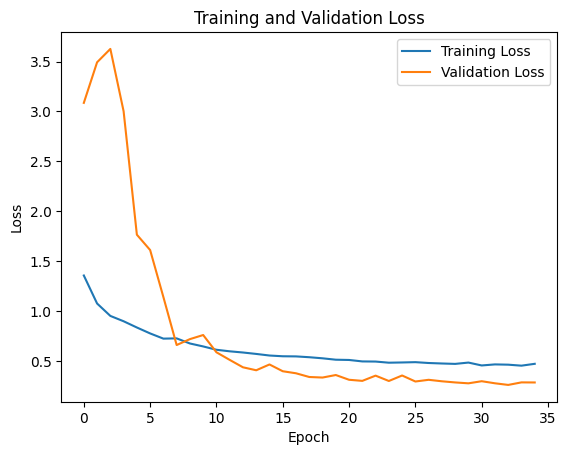

In [14]:
import matplotlib.pyplot as plt

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_graph.png')
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np

# Define image dimensions and batch size
img_height, img_width = 300, 300
batch_size = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess the test data
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Leaf Disease Dataset/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the saved model
loaded_model = load_model('/content/my_model.h5')

# Generate predictions on the test set using the loaded model
predictions = loaded_model.predict(test_generator)

# Extract predicted labels and true labels
predicted_labels = np.argmax(predictions[0], axis=1)  # Assuming the first output is for classification
true_labels = test_generator.classes

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Calculate and display the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


Found 180 images belonging to 9 classes.
6/6 [==============================] - 45s 9s/step
Classification Report:
                         precision    recall  f1-score   support

                Healthy       1.00      1.00      1.00        20
  Mild Bacterial blight       1.00      1.00      1.00        20
             Mild Blast       1.00      0.90      0.95        20
         Mild Brownspot       1.00      1.00      1.00        20
            Mild Tungro       0.95      1.00      0.98        20
Severe Bacterial blight       1.00      1.00      1.00        20
           Severe Blast       0.91      1.00      0.95        20
       Severe Brownspot       1.00      1.00      1.00        20
          Severe Tungro       1.00      0.95      0.97        20

               accuracy                           0.98       180
              macro avg       0.98      0.98      0.98       180
           weighted avg       0.98      0.98      0.98       180



In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# Define image dimensions and batch size
img_height, img_width = 300, 300
batch_size = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess the training data
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Leaf Disease Dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

# Load and preprocess the validation data
val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Leaf Disease Dataset/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify validation subset
)

# Build the CNN model with Batch Normalization
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# Compile the model with RMSProp optimizer
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Learning rate scheduler
def lr_scheduler(epoch):
    return 0.001 * pow(0.9, epoch)

lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_generator, epochs=35, validation_data=val_generator, callbacks=[lr_callback])
model.save('my_model_rmsprop_with_bn.h5')


Found 2268 images belonging to 9 classes.
Found 36 images belonging to 9 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 298, 298, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 298, 298, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 147, 147, 64)      18496     
                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np

# Define image dimensions and batch size
img_height, img_width = 300, 300
batch_size = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess the test data
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Leaf Disease Dataset/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the saved model
loaded_model = load_model('/content/my_model_rmsprop_with_bn.h5')  # Update the path if needed

# Generate predictions on the test set using the loaded model
predictions = loaded_model.predict(test_generator)

# Extract predicted labels and true labels
predicted_labels = np.argmax(predictions, axis=1)  # Use axis=0 if predictions is a 1D array
true_labels = test_generator.classes

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Calculate and display the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


Found 180 images belonging to 9 classes.
6/6 [==============================] - 5s 675ms/step
Classification Report:
                         precision    recall  f1-score   support

                Healthy       1.00      1.00      1.00        20
  Mild Bacterial blight       1.00      1.00      1.00        20
             Mild Blast       1.00      0.85      0.92        20
         Mild Brownspot       1.00      1.00      1.00        20
            Mild Tungro       0.95      1.00      0.98        20
Severe Bacterial blight       1.00      1.00      1.00        20
           Severe Blast       0.87      1.00      0.93        20
       Severe Brownspot       1.00      1.00      1.00        20
          Severe Tungro       1.00      0.95      0.97        20

               accuracy                           0.98       180
              macro avg       0.98      0.98      0.98       180
           weighted avg       0.98      0.98      0.98       180

